## QF5204: Assignment 4


### First derivative: Richardson extrapolation

Write a function to compute the derivative $f'(x_0)$ of the function $f$ of an unknown form, using Richardson extrapolation with the central difference g(h) and the step sizes $h$ and $\frac{h}{2}$. Conduct some simple test cases for the function.

In [1]:
from typing import Callable


def MyFirstDeriv(f: Callable, x0: float, h: float):
    def g(_h: float) -> float:
        return (f(x0 + _h) - f(x0 - _h)) / (2 * _h)

    return (4*g(h / 2) - g(h)) / 3

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def test_MyFirstDeriv(f: Callable, f_dash: Callable, fname: str):
    h_range = np.logspace(-9, 0, 50)
    
    for x0 in [-1, 0, 1]:
        plt.plot(h_range, [abs(MyFirstDeriv(f, x0, h) - f_dash(x0)) for h in h_range], label=f"x0={x0}")
    plt.xscale('log')
    plt.xlabel('h')
    plt.yscale('log')
    plt.ylabel('error')
    plt.title(f"Derivative of {fname}")
    plt.legend()

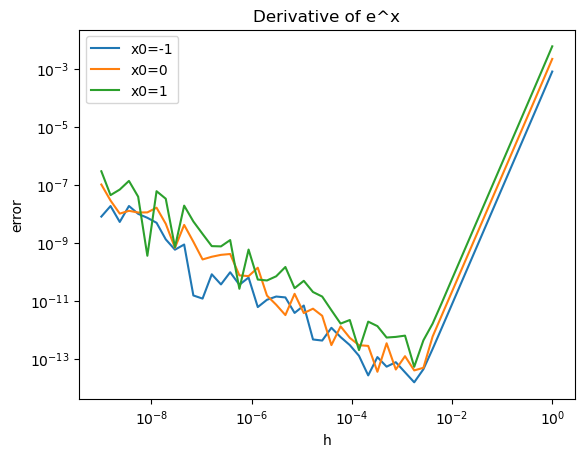

In [3]:
import math


test_MyFirstDeriv(math.exp, math.exp, "e^x")

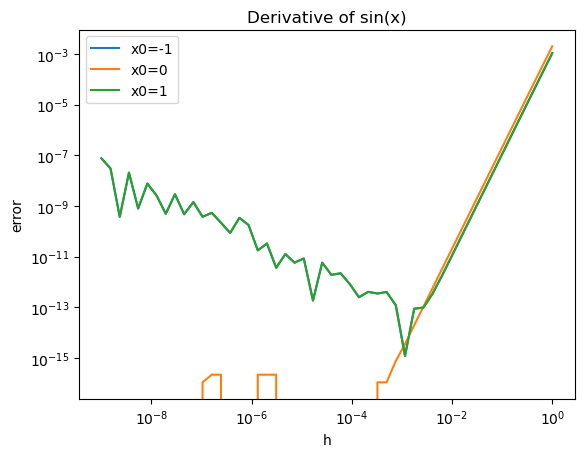

In [4]:
test_MyFirstDeriv(math.sin, math.cos, "sin(x)")

In [5]:
def f(x: float) -> float:
    return x**3 + 3*x - 1

def f_dash(x: float) -> float:
    return 3*x**2 + 3

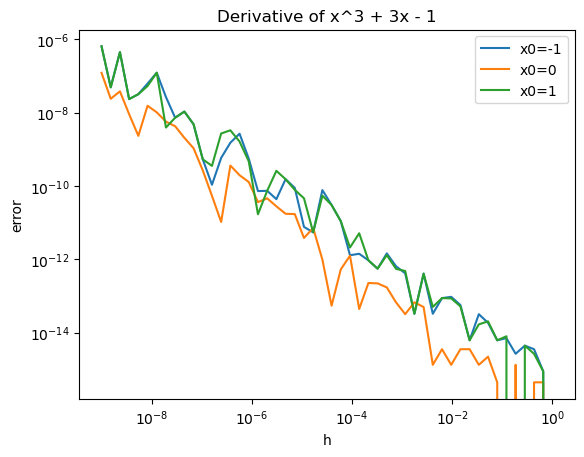

In [6]:
test_MyFirstDeriv(f, f_dash, "x^3 + 3x - 1")

For `exp` and `sin`, as `h` decreases, the error decreases as well. However, after a certain small `h`, the error actually increases (but still within acceptable ranges).

### American Puts: Smooth Binomial Tree

This exercise considers a smoothed version of binomial tree pricer for American put options.
Unlike the standard binomial tree pricer that evaluates the payoff function at the final time step,
we can skip the final time step payoff evaluation, but start from the second last time step by applying Black-Scholes analytic formula for European put option to calculate the continuation value.
This is because the American early exercise feature vanishes at the last time step. So at the second time step, if the option holder decides not to exercise, he/she has left with a European option with time to expiry equal to the time interval $\Delta t$.
Note that you still need to update the node's value using maximum of continuation value and exercise value at the second last step.
Compared with the standard tree pricer where the final time slice is a non-differentiable function at the strike,
the smooth Black-Scholes analytic formula would help stablizing the risk sensitivities.

Implement the smoothed version of binomial tree pricer with CRR calibrator.

Some pre-requisite classes and functions (`Option`, `bs_pricer`, `binomial_pricer`):

In [7]:
from enum import Enum


PriceType = float


class OptionType(Enum):
    CALL = 1
    PUT = 2


class Option:
    def __init__(self,
                 K: PriceType,
                 option_type: OptionType):
        self.K = K
        self.option_type = option_type

    def get_strike_price(self) -> PriceType:
        return self.K

    def get_option_type(self) -> OptionType:
        return self.option_type

    def is_call(self) -> bool:
        return self.get_option_type() == OptionType.CALL

    def is_put(self) -> bool:
        return self.get_option_type() == OptionType.PUT

    def simple_payoff(self, S: PriceType) -> PriceType:
        if self.is_call():
            return max(S - self.get_strike_price(), 0)
        if self.is_put():
            return max(self.get_strike_price() - S, 0)
        raise NotImplementedError()

    def payoff(self, S: PriceType, T: float = 0) -> PriceType:
        raise NotImplementedError()


def is_close(a: float, b: float, tol=1e-6) -> bool:
    return abs(a - b) < tol


class EuropeanOption(Option):
    def payoff(self, S: PriceType, T: float = 0) -> PriceType:
        return 0 if not is_close(T, 0) else super().simple_payoff(S)


class AmericanOption(Option):
    def payoff(self, S: PriceType, T: float = 0) -> PriceType:
        return super().simple_payoff(S)

In [8]:
from scipy.stats import norm


def bs_pricer(option: EuropeanOption,
             S: PriceType,
             r: float,
             sigma: float,
             T: float) -> PriceType:
    K = option.get_strike_price()

    # Compute d +/-
    sd = sigma * math.sqrt(T)

    d1 = (math.log(S / K) + r * T)/sd + sd/2
    d2 = d1 - sd

    D = math.exp(-r*T)

    if option.is_call():
        return S*norm.cdf(d1) - K*D*norm.cdf(d2)
    if option.is_put():
        return K*D*norm.cdf(-d2) - S*norm.cdf(-d1)

    raise ValueError(f"Unsupported option type: {option.get_option_type()}")

In [9]:
def crr_calibrator(r: float, sigma: float, t: float) -> tuple[float, float, float]:
    b = math.exp((r + sigma*sigma) * t) + math.exp(-r*t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (u*math.exp(r*t) - 1) / (u*u - 1) if u != 1 else 1/2
    return (u, 1/u, p)


def binomial_pricer(option: Option,
                    S: PriceType,
                    r: float,
                    sigma: float,
                    T: float,
                    calibrator: Callable = crr_calibrator,
                    num_steps: int = 100) -> PriceType:
    dt = T / num_steps
    u, d, p = calibrator(r, sigma, dt)

    value = [option.payoff((u ** (num_steps - i)) * (d ** i) * S) for i in range(num_steps + 1)]

    D = math.exp(-r*dt)
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            tau = T - i*dt

            current_payoff = option.payoff((u ** (i - j)) * (d ** j) * S, tau)
            expected_payoff_upon_continuation = D * (p*value[j] + (1 - p)*value[j + 1])

            # Note: for European options, current_payoff is 0
            value[j] = max(current_payoff, expected_payoff_upon_continuation)

    return value[0]

In [10]:
def smooth_binomial_pricer(option: Option,
                           S: PriceType,
                           r: float,
                           sigma: float,
                           T: float,
                           calibrator: Callable = crr_calibrator,
                           num_steps: int = 100) -> PriceType:
    dt = T / num_steps
    u, d, p = calibrator(r, sigma, dt)

    value = [0] * num_steps

    D = math.exp(-r*dt)
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            tau = T - i*dt

            current_spot = (u ** (i - j)) * (d ** j) * S
            current_payoff = option.payoff(current_spot, tau)
            if i == num_steps - 1:
                european_option = EuropeanOption(K, option.get_option_type())
                expected_payoff_upon_continuation = bs_pricer(european_option, current_spot, r, sigma, tau)
            else:
                expected_payoff_upon_continuation = D * (p*value[j] + (1 - p)*value[j + 1])

            # Note: for European options, current_payoff is 0
            value[j] = max(current_payoff, expected_payoff_upon_continuation)

    return value[0]

Conduct two test cases:

1) Plot the option's delta (using MyFirstDeriv implemented in Exercise 1 with step size $h$ set to 1 dollar)
for $n$ from 5 to 200, for both the smoothed version of the pricer and the standard American put option pricer given in the example code,
with $S = 100, K = 108, T = 1, v = 15\%, r = 3\%$.

2) Plot the option's delta
for $S$ from 75 to 150, for both the smoothed version of the pricer and the standard American put option pricer given in the example code,
with $n = 200, K = 108, T = 1, v = 15\%, r = 3\%$.

In [11]:
S, K, r, vol, T = 100, 108, 0.03, 0.15, 1

american_put = AmericanOption(K, OptionType.PUT)
smooth_binomial_pricer(american_put, S, r, vol, T), binomial_pricer(american_put, S, r, vol, T)

(9.575660367783879, 9.58107547459517)

In [12]:
def compute_delta(option: Option,
                  S: PriceType,
                  r: float,
                  sigma: float,
                  T: float,
                  pricer: Callable = smooth_binomial_pricer,
                  num_steps: int = 100,
                  h: float = 1) -> float:
    def f(s: float) -> float:
        return pricer(option, s, r, sigma, T, num_steps=num_steps)
    return MyFirstDeriv(f, S, h)

Text(0.5, 1.0, 'Delta vs num_steps')

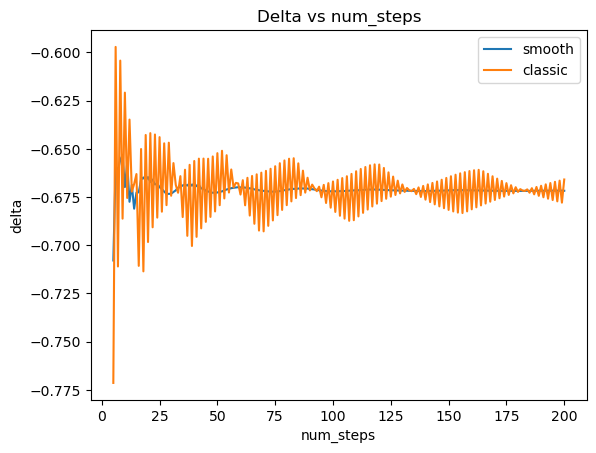

In [13]:
n_range = range(5, 200 + 1)
plt.plot(n_range,
         [
             compute_delta(american_put, S, r, vol, T, pricer=smooth_binomial_pricer, num_steps=num_steps)
             for num_steps in n_range
         ], label="smooth")
plt.plot(n_range,
         [
             compute_delta(american_put, S, r, vol, T, pricer=binomial_pricer, num_steps=num_steps)
             for num_steps in n_range
         ], label="classic")

plt.legend()
plt.xlabel("num_steps")
plt.ylabel("delta")
plt.title("Delta vs num_steps")

Text(0.5, 1.0, 'Delta vs S (num_steps = 200)')

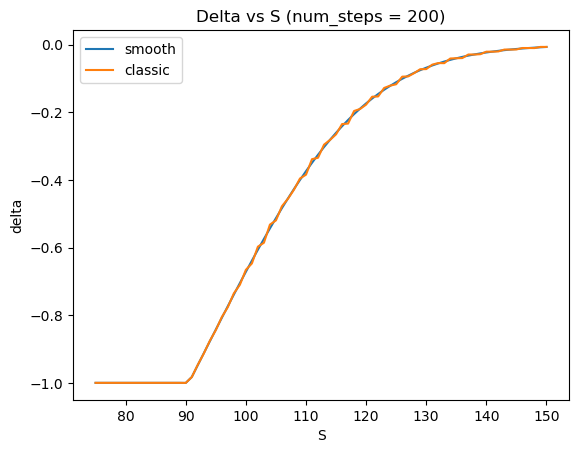

In [14]:
S_range = range(75, 150 + 1)
plt.plot(S_range,
         [
             compute_delta(american_put, S, r, vol, T, pricer=smooth_binomial_pricer, num_steps=200)
             for S in S_range
         ], label="smooth")
plt.plot(S_range,
         [
             compute_delta(american_put, S, r, vol, T, pricer=binomial_pricer, num_steps=200)
             for S in S_range
         ], label="classic")

plt.legend()
plt.xlabel("S")
plt.ylabel("delta")
plt.title("Delta vs S (num_steps = 200)")

Text(0.5, 1.0, 'Delta vs S (num_steps = 50)')

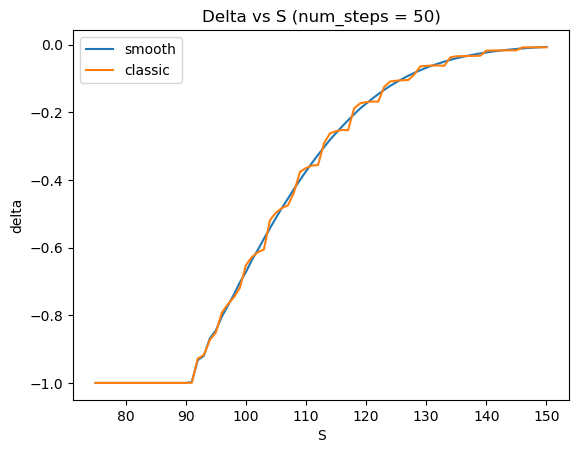

In [15]:
S_range = range(75, 150 + 1)
plt.plot(S_range,
         [
             compute_delta(american_put, S, r, vol, T, pricer=smooth_binomial_pricer, num_steps=50)
             for S in S_range
         ], label="smooth")
plt.plot(S_range,
         [
             compute_delta(american_put, S, r, vol, T, pricer=binomial_pricer, num_steps=50)
             for S in S_range
         ], label="classic")

plt.legend()
plt.xlabel("S")
plt.ylabel("delta")
plt.title("Delta vs S (num_steps = 50)")

Indeed, `smooth_binomial_pricer` has smoother curves compared to classic `binomial_pricer` in both test cases (delta vs num_steps and delta vs S).

### Double No Touch Option: Crank-Nicolson scheme

A double no touch option has two barrier levels: upBarrier and downBarrier.
When the stock price touches one of the barriers the option is terminated.
If the barriers are not touched until the option expiry date, the option pays 1 dollar.

Implement a double no touch option pricer in PDE with Crank-Nicolson scheme.

When the spot is beyond the up and down barriers the option worths 0,
so we can set the boundaries of the S grid at exactly the up and down barrier levels, and use Dirichlet boundary condition.

In [16]:
def dntPDEPricer(S0: PriceType,
                 r: float,
                 q: float | None,
                 vol: float,
                 T: float,
                 upBarrier: PriceType,
                 downBarrier: PriceType,
                 nT: int = 100,
                 nS: int = 100) -> PriceType:

    dS = (upBarrier - downBarrier) / (nS - 1)
    S = np.arange(downBarrier, upBarrier + dS/2, dS)

    v = np.ones_like(S)
    v[0] = v[-1] = 0

    M = np.zeros((nS, nS))
    M[0, 0], M[-1, -1] = 1, 1

    a, b = (r - (q or 0)) / (2 * dS),  (vol * vol) / (dS * dS)
    i = np.arange(1, nS - 1)
    M[i, i] = (r + b*S*S)[1: -1]
    M[i, i - 1] = (-(b/2)*S*S + a*S)[1: -1]
    M[i, i + 1] = (-(b/2)*S*S - a*S)[1: -1]

    Ih = np.eye(nS)
    Ih[0, 0] = Ih[-1, -1] = 0.5

    dt = T / (nT - 1)
    M = np.linalg.inv(Ih + 0.5 * dt * M) @ (Ih - 0.5 * dt * M)
    v = np.linalg.matrix_power(M, nT - 1).dot(v)

    return np.interp(S0, S, v)

For $S_0 = 100, T = 1, \sigma = 15\%, r = 5\%, q = 3\%, nT = 100, nS = 100$,
plot the double no touch price as a function of x which determines the barrier levels: upBarrier = 100+x, downBarrier = 100-x. What should be the price converges to when x is large enough?
Verify that is the case in the plot.

Converged price:  0.9512226345609174


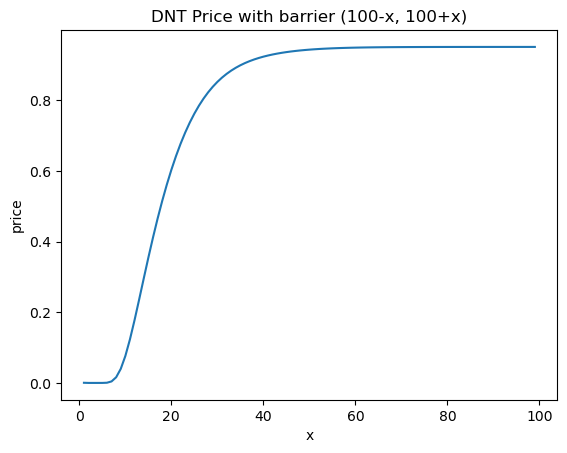

In [17]:
S0, r, q, vol, T = 100, 0.05, 0.03, 0.15, 1
nT, nS = 100, 100

x_range = range(1, S0)
prices = [dntPDEPricer(S0, r, q, vol, T, 100 + x, 100 - x, nT, nS) for x in x_range]
plt.plot(x_range, prices)
plt.xlabel("x")
plt.ylabel("price")
plt.title("DNT Price with barrier (100-x, 100+x)")
print("Converged price: ", prices[-1])

When x is very large, the price is almost certainly within the barriers, so the payoff is 1. The price should converge to the discounted payoff:

In [18]:
math.exp(-r*T) * 1

0.951229424500714

### ODE solvers

#### Euler's Explicit method

The function returns the value $y$ at the given $x$ by solving the ODE:
$$ y' = f(x,y) $$
with initial value $(x_0, y_0)$ and number of time steps $n$.

In [19]:
def eulerODEExplicit(f: Callable, x0: float, y0: float, n: int, x: float) -> float:
    h = (x - x0) / n

    x, y = x0, y0
    for i in range(n):
        x, y = x + h, y + h * f(x, y)

    return y

#### Euler's Implicit method

ODE: $y' = -3y$

In [20]:
def eulerODEImplicit(x0: float, y0: float, n: int, x: float) -> float:
    h = (x - x0) / n

    x, y = x0, y0
    for i in range(n):
        x, y = x + h, y / (1 + 3*h)

    return y

#### Crank-Nicholson

In [21]:
def eulerODECrankN(x0: float, y0: float, n: int, x: float) -> float:
    h = (x - x0) / n

    x, y = x0, y0
    for i in range(n):
        x, y = x + h, y * (2 - 3*h) / (2 + 3*h)
    return y

Let's consider the relative error as the actual y values very large or very small when far away from 0.

In [22]:
def relative_error(a: float, b: float) -> float:
    return abs((a - b) / b)


def test_ode_solvers(f: Callable, y: Callable, x0: float, y0: float, n: int, x_range):
    plt.plot(x_range, [relative_error(eulerODEExplicit(f, x0, y0, n, x), y(x)) for x in x_range], label="explicit")
    plt.plot(x_range, [relative_error(eulerODEImplicit(x0, y0, n, x), y(x)) for x in x_range], label="implicit")
    plt.plot(x_range, [relative_error(eulerODECrankN(x0, y0, n, x), y(x)) for x in x_range], label="crankn")
    
    plt.yscale('log')
    plt.xlabel('x')
    plt.ylabel('relative error')
    plt.title(f"Solution errors: y' = -3y; (x0, y0) = (0, 1); n = {n}")
    plt.legend()

In [23]:
# y' = f(x, y) = -3y
# y = Cexp(-3x) and C = y(0) = 1

def f(x: float, y: float) -> float:
    return -3*y

def y(x: float) -> float:
    return math.exp(-3*x)

#### Testing

Compute $y$ for $x \in [-15, -14, \dots, 14, 15]$ with $(x_0, y_0) = (0, 1)$ and a suitable choice of $n$.

Compute the error for each method and each $x$ and explain the source of errors.

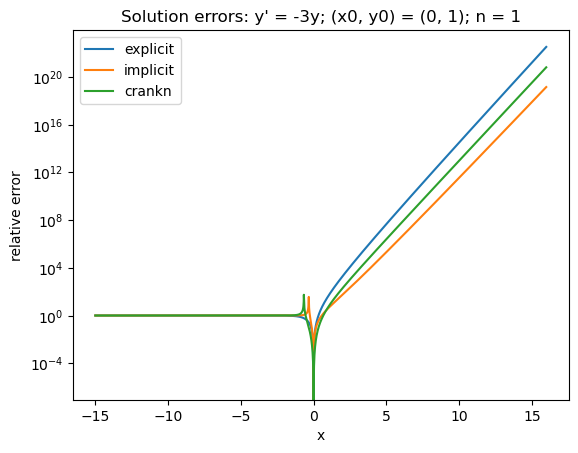

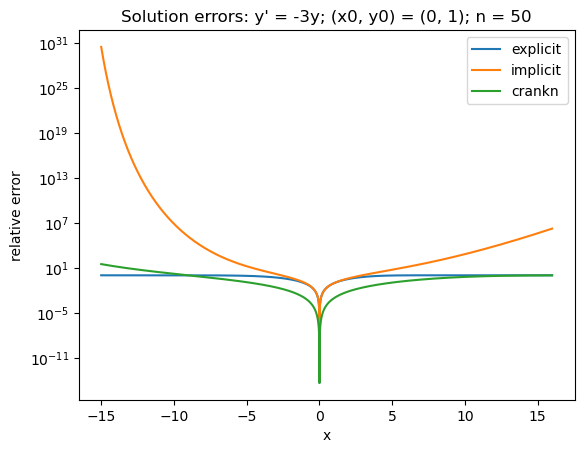

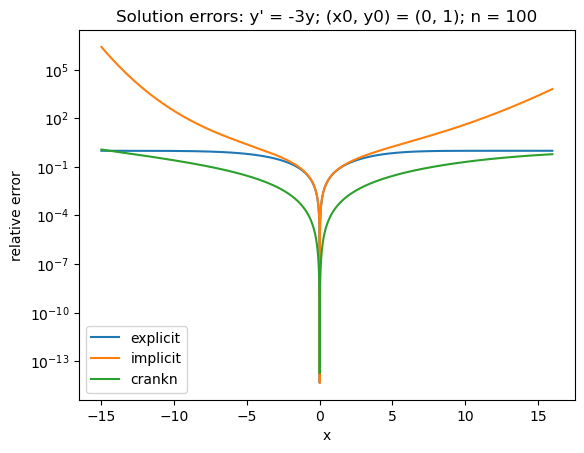

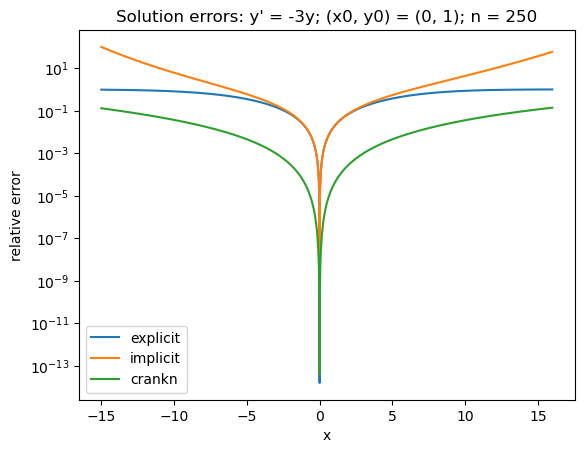

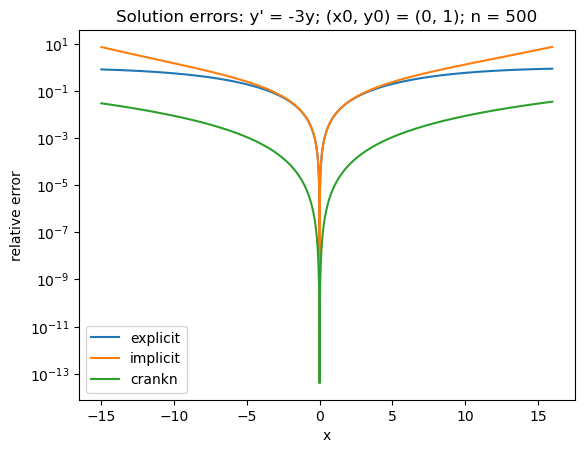

In [24]:
x0, y0 = 0, 1
x_range = np.arange(-15, 15 + 1, 0.01)

for n in [1, 50, 100, 250, 500]:
    test_ode_solvers(f, y, x0, y0, n, x_range)
    plt.show()

**Sources of errors**

0. Rounding-off: Since computers perform finite precision arithmetic, we can have rounding-off errors.
1. Truncation: we have $y(x + h) = y(x) + hf(x, y) + O(h^2)$ and while computing, we drop the $O(h^2)$ terms for being too small.
2. Discretization/step-size: large h (small n) do not accurately represent the continuous space that is discretized.
3. Stability: while implicit Euler and Crank-Nicolson are unconditionally stable, explicit Euler requires $|1 - \frac{3x}{n}| < 1$, i.e., $0 < x < \frac{2n}{3}$ to be stable.

Points further away from $x_0 = 0$ have larger errors. Crank-Nicolson is stable and more accurate compared to the other 2 methods especially when $x$ is close to $x_0$ and $n$ is large enough.